# Prophet's Prophecy
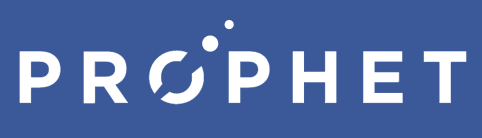

This competition is pretty much ruined with all the scraping opportunities to hunt down the test data labels. A lot of us are here to learn true Data Science. This notebook is for such people.

Prophet is a time series model open sourced by Facebook in 2017:  https://facebook.github.io/prophet/

The notebook shows the building blocks for using Prophet to forecast the energy consumption. We will be building a Prophet model for each **building x meter** combination.

In [ ]:
## importing packages
import itertools
import gc

import numpy as np
import pandas as pd

from fbprophet import Prophet
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

## defining paths
path_data = "/kaggle/input/ashrae-energy-prediction/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

## setting seed
myfavouritenumber = 13
seed = myfavouritenumber
np.random.seed(seed)

Since Prophet is built for every building-meter combination, it exceeds the 9-hr runtime limit of Kaggle Notebook. Hence we will run it separately for each site_id. Note that you can run these in parallel on Kaggle.

Notebook versions for each site run -   
Site 0: https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy?scriptVersionId=24024737   
Site 1: https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy?scriptVersionId=24024752   
Site 2: https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy?scriptVersionId=24024767   
Site 3: https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy?scriptVersionId=24024791   
Site 4: https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy?scriptVersionId=24024811   
Site 5: https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy?scriptVersionId=24024832   
Site 6: https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy?scriptVersionId=24024853   
Site 7: https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy?scriptVersionId=24024873   
Site 8: https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy?scriptVersionId=24024895   
Site 9: https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy?scriptVersionId=24024904   
Site 10: https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy?scriptVersionId=24039606   
Site 11: https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy?scriptVersionId=24039629   
Site 12: https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy?scriptVersionId=24039651   
Site 13: https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy?scriptVersionId=24039661   
Site 14: https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy?scriptVersionId=24039680   
Site 15: https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy?scriptVersionId=24039699   

In [ ]:
## site can be changed to run the notebook for different sites (choosing 11 here since it runs the fastest)
site = 11

# Preparing data
Preparing the train and test data with weather features and in the format required by Prophet.

In [ ]:
## reading train and test data
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

## reading building metadata
building = pd.read_csv(path_building)
df_train = df_train.merge(building, on="building_id")
df_test = df_test.merge(building, on="building_id")

## reading weather data
weather_train = pd.read_csv(path_weather_train)
weather_test = pd.read_csv(path_weather_test)

## expanding weather data to all missing values
weather_train = pd.merge(pd.DataFrame(list(itertools.product(df_train.site_id.unique(), df_train.timestamp.unique())), columns=["site_id", "timestamp"]),
                         weather_train, on = ["site_id", "timestamp"], how="left")
weather_test = pd.merge(pd.DataFrame(list(itertools.product(df_test.site_id.unique(), df_test.timestamp.unique())), columns=["site_id", "timestamp"]),
                         weather_test, on = ["site_id", "timestamp"], how="left")

## filling missing values with closest available values
weather_train = weather_train.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))
weather_test = weather_test.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))

## preparing final train data
df_train = df_train.merge(weather_train, on=["site_id", "timestamp"], how="left")
df_train = df_train[~((df_train.site_id==0) & (df_train.meter==0) & (df_train.building_id <= 104) & (df_train.timestamp < "2016-05-21"))]
df_train = df_train[df_train.site_id == site]
df_train.reset_index(drop=True, inplace=True)
df_train["ds"] = pd.to_datetime(df_train.timestamp, format='%Y-%m-%d %H:%M:%S')
df_train["y"] = np.log1p(df_train.meter_reading)

## preparing final test data
df_test = df_test.merge(weather_test, on=["site_id", "timestamp"], how="left")
df_test = df_test[df_test.site_id == site]
df_test.reset_index(drop=True, inplace=True)
df_test["ds"] = pd.to_datetime(df_test.timestamp, format='%Y-%m-%d %H:%M:%S')

## deleting unneeded dataset
del building, weather_train, weather_test
gc.collect()

# Prophet model
Building a Prophet model for each building x meter combination.

In [ ]:
## external features
exogenous_features = ["air_temperature", "cloud_coverage", "dew_temperature",
                      "precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed"]

## list of predictions
df_preds = []

## iterating over buildings
for building in df_train.building_id.unique():
    
    ## subsetting building data
    df_train_building = df_train[df_train.building_id == building]
    df_test_building = df_test[df_test.building_id == building]
    
    ## iterating over meters
    for meter in df_train_building.meter.unique():
        
        ## subsetting meter data
        df_train_building_meter = df_train_building[df_train_building.meter == meter]
        df_test_building_meter = df_test_building[df_test_building.meter == meter]
        
        ## drop features with all NaNs
        df_train_building_meter.dropna(axis=1, how="all", inplace=True)
        
        print("Building Prophet model for building", building, "and meter", meter)
        
        ## initializing model
        model_prophet = Prophet()
        
        ## adding regressors
        remove_features = []
        
        for feature in exogenous_features:
            if feature in df_train_building_meter.columns:
                model_prophet.add_regressor(feature)
            else:
                remove_features.append(feature)

        for feature in remove_features:
            exogenous_features.remove(feature)
        
        ## building model
        model_prophet.fit(df_train_building_meter[["ds", "y"] + exogenous_features])
        
        ## forecasting predictions
        forecast = model_prophet.predict(df_test_building_meter[["ds"] + exogenous_features])
        
        ## creating predictions dataframe
        df_pred = pd.DataFrame({"row_id": df_test_building_meter.row_id.values, "meter_reading": np.expm1(forecast.yhat.values)})
        df_preds.append(df_pred)

        print("Prophet model completed for building", building, "and meter", meter, "\n")
        
        ## cleanup
        gc.collect()

In [ ]:
## visualizing last model built
model_prophet.plot_components(forecast)

# Saving Predictions
Saving predictions for the site. The final submission file will be combining the predictions of all sites together.

In [ ]:
## saving predictions
df_site = pd.concat(df_preds).reset_index(drop=True)
df_site.to_csv("prophet_pred_site_" + str(site) + ".csv", index=False)